# Predicting Red Hat Business Value

Team members: Colby Meline, Yu-Ting Chen

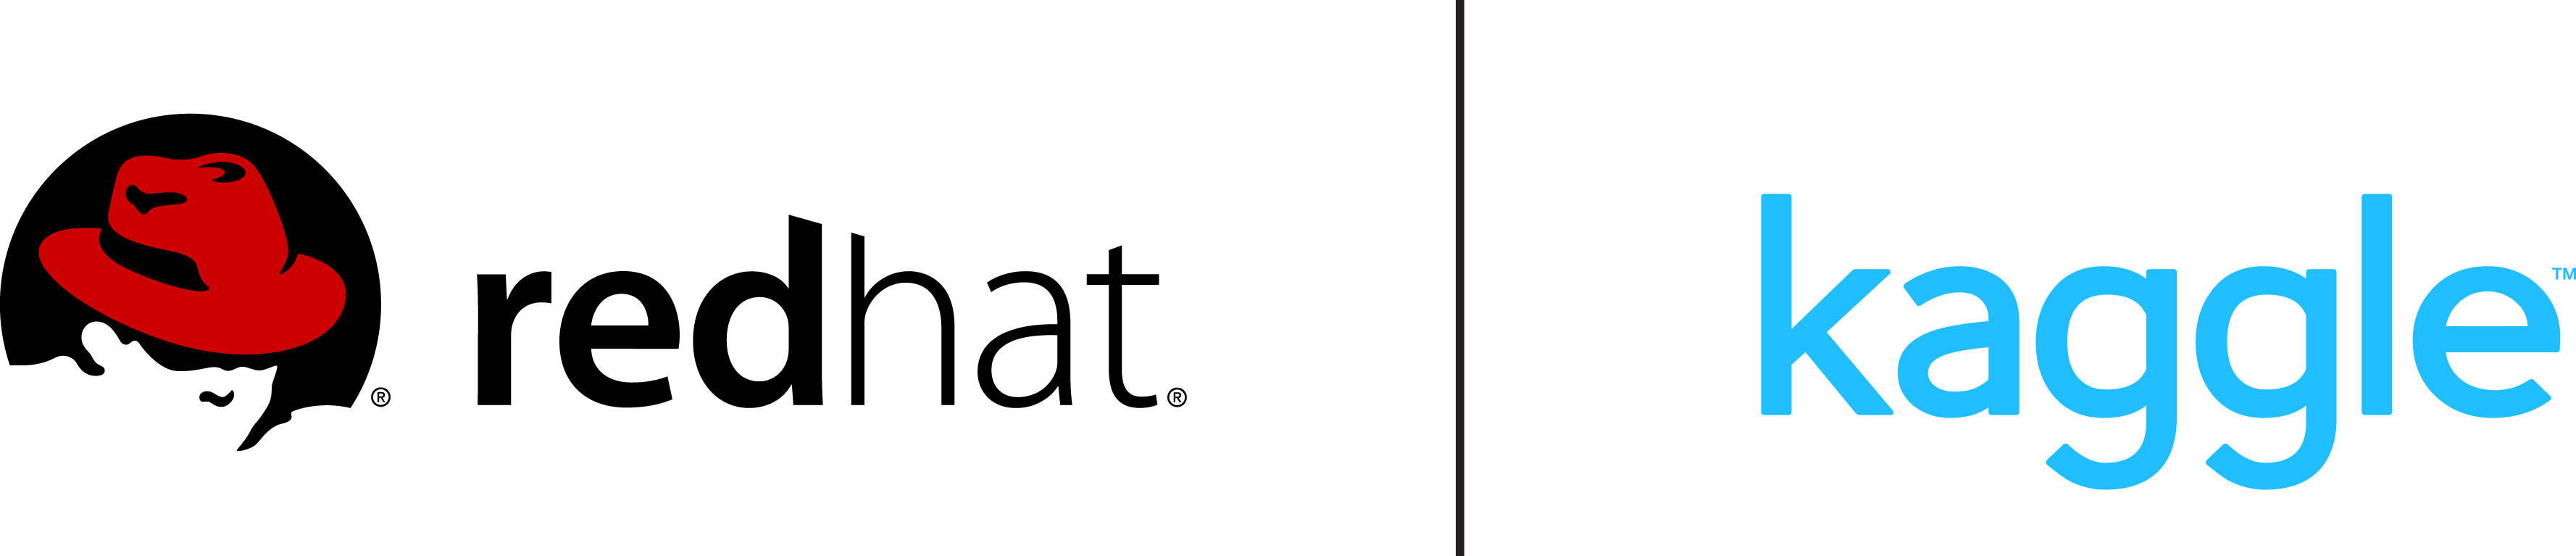

## Project Goals & Business Relevance

<br>

Like most companies, Red Hat is able to gather a great deal of information over time about the behavior of individuals who interact with them. They’re in search of better methods of using this behavioral data to predict which individuals they should approach—and even when and how to approach them.

Our project goal is to accurately identify which Red Hat customers have the most potential business value for Red Hat based on their characteristics and activities.

The outcome of this work is to more efficiently prioritize resources to generate business and better serve their customers.

<br>


## Data Collection/Description

<br>

Red Hat provided two datasets for this project: a people file and an activity file. The people file contains all unique people in the data (along with corresponding characteristics), and the activity file contains data collected about their activities. The business value outcome is defined by the yes/no field attached to each unique activity that has been completed within a fixed window of time after each unique activity was performed. There are nine different activities joined to people using the shared person_id as the common key. All data is categorical with the exception of one feature (char_38) which is a continuous numerical variable.

<br>


## Getting Started with Google Colab and PySpark

<br>

### What is Spark?

Spark and, by extension, PySpark have gained a ton of popularity in recent years because of the power Spark provides to developers in working with big data sets efficiently. Spark is built to handle data as large as the Pedabyte scale, which is equivalent to 1,000,000 Gigabytes!

<br>

### How does it work?

[Spark](https://spark.apache.org/) is described by Apache (the maintainers of the tool) as, "a multi-language engine for executing data engineering, data science, and machine learning on single-node machines or clusters."


Basically, under the hood, Spark distributes the work you ask it to do to one or more workers ("nodes") which do their work separately, in parallel. They organize the steps they're supposed to take in a Directed Acyclic Graph, which is essentially a list of instructions for each worker to follow.


When each worker finishes the work they've been assigned, they come together at the end and combine all of the work they did separately. If you'd like to read more about how this process works in a more technical sense, I'd recommend reading [this StackOverflow answer and the articles they link to.](https://stackoverflow.com/a/54508672)

<br>

### Where does Python fit into all of this?

Spark is written in the Scala programming language, so it wasn't always possible to leverage the power of Spark unless you knew how to write code in Scala. More recently, Apache has made it possible to use Spark by writing code in Python, SQL, Scala, Java or R.

Python's application programming interface (API) for communicating with Spark is called PySpark, and can be a great tool to learn if you're someone who works with data.

<br>

### So what are we going to do?


##### *Preface: we'll be using [Google Colab](https://colab.research.google.com) for our data analysis to make it easier to download and use Spark. This will be an easier introduction than using your local machine, because you can avoid troubleshooting any installation issues you may encounter with getting Spark up and running on your unique device. Google Colab is free to use if you sign in with a Google account.*

<br>

As an introduction to using Spark, we're going to use it to do some data wrangling and basic machine-learning on the [RedHat dataset from Kaggle](https://www.kaggle.com/c/predicting-red-hat-business-value).

1. First, we'll upload the data into our Colab environment. Make sure the .zip files are downloaded onto your local machine from [Kaggle](https://www.kaggle.com/c/predicting-red-hat-business-value).
2. We'll unzip the .zip files so we can access the data using Python.
3. We'll join the act_train dataset with the people dataset on the "people_id" column.
4. We'll fill in missing values in the data.
5. We'll transform the String columns into numbers so that we can use the data with machine-learning models.
6. We'll fit a model from pyspark.ml to the data.
7. We'll make some predictions using the model.

##### *Note: if you see a code block that starts with an exclamation mark (!), that code block is a shell command. Shell and BASH are versions of the Linux command line that enable you to do tons of really cool stuff with your operating system like organizing files, searching for things, downloading files from the internet, networking, and anything else you can think of. Google Colab is running on Linux in the cloud, so we have to use Shell commands for some things.* 

In [ ]:
import os
from google.colab import files

In [ ]:
filenames = ["act_train.csv.zip", "act_test.csv.zip", "people.csv.zip", "sample_submission.csv.zip"]  # upload these

In [ ]:
path = "/home/colby/Downloads"
files.upload()  # tried to upload programmatically with "upload_file" method, colab disallows this.

Saving people.csv.zip to people.csv.zip
Saving act_train.csv.zip to act_train.csv.zip


In [ ]:
for filename in filenames:
  os.system("unzip {}".format(filename))

In [ ]:
!ls

act_train.csv	   people.csv	   spark-3.3.1-bin-hadoop3
act_train.csv.zip  people.csv.zip  spark-3.3.1-bin-hadoop3.tgz
merged_train.csv   sample_data


### Pandas Comparison Section

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
act_train = pd.read_csv("act_train.csv")
# act_test = pd.read_csv("act_test.csv")
people = pd.read_csv("people.csv")
merged = act_train.merge(people, on=["people_id"], how="inner")

del act_train
del people

In [ ]:
numerical_columns = ['people_id', 'activity_id', 'group_1', 'char_38', 'date_Day', 'activity_date_Day']
categorical_columns = ['activity_category']
for column in merged.columns:
    if column.startswith("char_") and column != "char_38":
        categorical_columns.append(column)

In [ ]:
categorical_columns

['activity_category',
 'char_1_x',
 'char_2_x',
 'char_3_x',
 'char_4_x',
 'char_5_x',
 'char_6_x',
 'char_7_x',
 'char_8_x',
 'char_9_x',
 'char_10_x',
 'char_1_y',
 'char_2_y',
 'char_3_y',
 'char_4_y',
 'char_5_y',
 'char_6_y',
 'char_7_y',
 'char_8_y',
 'char_9_y',
 'char_10_y',
 'char_11',
 'char_12',
 'char_13',
 'char_14',
 'char_15',
 'char_16',
 'char_17',
 'char_18',
 'char_19',
 'char_20',
 'char_21',
 'char_22',
 'char_23',
 'char_24',
 'char_25',
 'char_26',
 'char_27',
 'char_28',
 'char_29',
 'char_30',
 'char_31',
 'char_32',
 'char_33',
 'char_34',
 'char_35',
 'char_36',
 'char_37']

In [ ]:
merged = merged.drop_duplicates([i for i in merged.columns if i != "activity_id"])
date_ref = np.datetime64("2020-01-01")
merged['date_Day'] = pd.Series([i - date_ref for i in pd.to_datetime(merged.date_x)]).dt.days
merged['activity_date_Day'] = pd.Series([i - date_ref for i in pd.to_datetime(merged.date_y)]).dt.days

In [ ]:
for i in range(1, 11):
  merged['char_{}_x'.format(i)] = merged['char_{}_x'.format(i)].fillna('type 0')

In [ ]:
compare = False
if compare:
  for i, act_df in enumerate([act_train]):  # , act_test
    # Merge and clean the data, make it numeric for neural network training
    merged = act_df.merge(people, on=["people_id"], how="inner")
    merged = merged.drop_duplicates([i for i in merged.columns if i != "activity_id"])
    date_ref = np.datetime64("2020-01-01")
    merged['date_Day'] = pd.Series([i - date_ref for i in pd.to_datetime(merged.date_x)]).dt.days
    merged['activity_date_Day'] = pd.Series([i - date_ref for i in pd.to_datetime(merged.date_y)]).dt.days

    numerify = lambda x: x.split("_")[1]
    under_columns = ["people_id", "activity_id"]
    for column in under_columns:
        merged[column] = merged[column].apply(numerify)
        merged[column] = pd.to_numeric(merged[column])

    def numerify(x):
      if type(x) == float:
        return x
      elif type(x) == str:
        return float(x.split(" ")[1])

    # numerify = lambda x: x.split(" ")[1]
    space_columns = ["group_1", "activity_category"]
    for column in space_columns:
        merged[column] = merged[column].apply(numerify)
        merged[column] = pd.to_numeric(merged[column])

    boolean_numerify = lambda x: x/1
    for column in categorical_columns[1:]:
        try:
            num = int(column.split("_")[1])
        except:
            print(column)
            break
        if num < 10 or column == "char_10_x":
            merged[column].fillna("type 0.0", inplace=True)
            merged[column] = merged[column].apply(numerify)
            merged[column] = pd.to_numeric(merged[column])
        elif num >= 10:
            merged[column].fillna(-1.0, inplace=True)
            merged[column] = merged[column].apply(boolean_numerify)
        # print("{}:\n{}".format(column, merged[column].unique()))
    merged.to_csv("merge{}.csv".format(i), index=False)

In [ ]:
merged.to_csv("merged_train.csv", index=False)

In [ ]:
!ls

act_train.csv	   people.csv	   spark-3.3.1-bin-hadoop3
act_train.csv.zip  people.csv.zip  spark-3.3.1-bin-hadoop3.tgz
merged_train.csv   sample_data


In [ ]:
merged = pd.read_csv("merged_train.csv")

In [ ]:
merged_train = merged

### Spark Installation

To work with Spark, we'll need a few things to be installed in our Colab environment:
1. PySpark (Python library for using Spark)
2. FindSpark (Python library for locating the computer resources / software required to start and talk to Spark)
3. Java Development Kit (JDK) to run Spark
4. Spark 3.3.1 from apache.org

In [ ]:
!pip install findspark pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 199 kB 60.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=3b561b4e4a856905fe6f9364fa708ca730d2255d821a2556457dac95abdff5a2
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

In [ ]:
!tar -xf spark-3.3.1-bin-hadoop3.tgz

In [ ]:
!ls /content/

sample_data  spark-3.3.1-bin-hadoop3  spark-3.3.1-bin-hadoop3.tgz


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3.tgz"

In [ ]:
# !sudo echo "spark.driver.memory 15g" > $SPARK_HOME/conf/spark-defaults.conf
# !cat $SPARK_HOME/conf/spark-defaults.conf

In [ ]:
import findspark
findspark.init("/content/spark-3.3.1-bin-hadoop3")
# from pyspark import SparkConf, SparkContext
# conf = SparkConf().setMaster("local[*]").setAppName("RedHat")
# sc = SparkContext(conf = conf)
#### These lines are to tell jupyter where to find Apache Spark ####

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "12g").appName("RedHat").getOrCreate()  #.config(conf=SparkConf())

In [ ]:
subset = merged_train[numerical_columns + categorical_columns + ["outcome"]]

In [ ]:
# subset.columns = range(101)
# subset["target"] = merged_train["target"]

In [ ]:
df = spark.createDataFrame(subset)

NameError: ignored

In [ ]:
from pyspark.sql.functions import col


act_train = spark.read.csv("act_train.csv", header=True) \
                .withColumnRenamed("char_1", "char_1_x") \
                .withColumnRenamed("char_2", "char_2_x") \
                .withColumnRenamed("char_3", "char_3_x") \
                .withColumnRenamed("char_4", "char_4_x") \
                .withColumnRenamed("char_5", "char_5_x") \
                .withColumnRenamed("char_6", "char_6_x") \
                .withColumnRenamed("char_7", "char_7_x") \
                .withColumnRenamed("char_8", "char_8_x") \
                .withColumnRenamed("char_9", "char_9_x") \
                .withColumnRenamed("char_10", "char_10_x") \
                .withColumnRenamed("date", "act_date")
people = spark.read.csv("people.csv", header=True)

duplicated_columns = []
for column in act_train.columns:
  if column in people.columns and column != "people_id":
    duplicated_columns.append(column)

# act_train = act_train.select(*(col(x).alias(x + '_act') for x in df1.columns))
# people = people.select(*(col(x).alias(x + '_act') for x in df1.columns))


duplicated_df = act_train.alias("x").join(people.alias("y"), on="people_id", how="inner")

In [ ]:
def rename_duplicate_columns(dataframe):
    columns = dataframe.columns
    duplicate_column_indices = list(set([columns.index(col) for col in columns if columns.count(col) == 2]))
    for index in duplicate_column_indices:
        columns[index] = columns[index]+'_2'
    dataframe = dataframe.toDF(*columns)
    return dataframe

numerical_columns = ['people_id', 'activity_id', 'group_1', 'char_38', 'date', 'act_date']
categorical_columns = ['activity_category']
for column in duplicated_df.columns:
    if column.startswith("char_") and column != "char_38":
        categorical_columns.append(column)

In [ ]:
df = rename_duplicate_columns(duplicated_df).select(numerical_columns + categorical_columns + ["outcome"])

### Basic EDA

Let's take a look at the basics of our dataset. How many rows do we have? How many columns?

In [ ]:
print((df.count(), len(df.columns)))

(2197291, 55)


In [ ]:
df.columns

['people_id',
 'activity_id',
 'group_1',
 'char_38',
 'date',
 'act_date',
 'activity_category',
 'char_1_x',
 'char_2_x',
 'char_3_x',
 'char_4_x',
 'char_5_x',
 'char_6_x',
 'char_7_x',
 'char_8_x',
 'char_9_x',
 'char_10_x',
 'char_1',
 'char_2',
 'char_3',
 'char_4',
 'char_5',
 'char_6',
 'char_7',
 'char_8',
 'char_9',
 'char_10',
 'char_11',
 'char_12',
 'char_13',
 'char_14',
 'char_15',
 'char_16',
 'char_17',
 'char_18',
 'char_19',
 'char_20',
 'char_21',
 'char_22',
 'char_23',
 'char_24',
 'char_25',
 'char_26',
 'char_27',
 'char_28',
 'char_29',
 'char_30',
 'char_31',
 'char_32',
 'char_33',
 'char_34',
 'char_35',
 'char_36',
 'char_37',
 'outcome']

We might want to see if strong patterns exist between groups and outcome, so let's look at the breakdown of each group by outcome.

We can use a spark.sql to run a simple aggregate SQL query, which we can use to count the number of 1's and 0's in outcome per group.

In [ ]:
spark.sql("SELECT group_1, outcome, count(*) from {df} group by group_1, outcome", df=df).show()

+-----------+-------+--------+
|    group_1|outcome|count(1)|
+-----------+-------+--------+
| group 1482|      1|    3243|
| group 5400|      0|     215|
| group 1011|      1|     491|
| group 1135|      1|      79|
| group 1589|      1|     139|
|  group 510|      1|     180|
|group 48798|      1|       2|
|group 10069|      1|     257|
|group 31588|      0|      57|
| group 4096|      1|     189|
|group 41702|      1|      11|
|group 38600|      0|      16|
|group 25223|      1|     179|
|group 18999|      0|     246|
|  group 408|      1|      19|
|group 34172|      1|       4|
|group 44523|      0|      39|
|group 39729|      1|      36|
|group 32431|      0|       1|
|group 26880|      1|      10|
+-----------+-------+--------+
only showing top 20 rows



Based on the numbers we have in the third column, it looks like the vast majority of rows belong to users who do not belong to any group!

We'll need to handle the missing data with some kind of imputation method.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression

Let's take a look at our Dataframe's "schema", which is just a breakdown of the Metadata of our Data: a description of what type of stuff is in each column.

In [ ]:
for i in df.schema:
  print(i)

StructField('people_id', StringType(), True)
StructField('activity_id', StringType(), True)
StructField('group_1', StringType(), True)
StructField('char_38', StringType(), True)
StructField('date', StringType(), True)
StructField('act_date', StringType(), True)
StructField('activity_category', StringType(), True)
StructField('char_1_x', StringType(), True)
StructField('char_2_x', StringType(), True)
StructField('char_3_x', StringType(), True)
StructField('char_4_x', StringType(), True)
StructField('char_5_x', StringType(), True)
StructField('char_6_x', StringType(), True)
StructField('char_7_x', StringType(), True)
StructField('char_8_x', StringType(), True)
StructField('char_9_x', StringType(), True)
StructField('char_10_x', StringType(), True)
StructField('char_1', StringType(), True)
StructField('char_2', StringType(), True)
StructField('char_3', StringType(), True)
StructField('char_4', StringType(), True)
StructField('char_5', StringType(), True)
StructField('char_6', StringType()

As you can see, there are a lot of columns. Many of them are strings, some are boolean, and some are numbers (long, double).

<br>

The basic overview of the data is that the data from the People dataset contains some data about the people present in both datasets. The Act_Train dataset contains data about what actions people performed on the RedHat website, and an "outcome" variable that represents whether or not they purchased something.

<br>

None of the column names or column data give us any clues regarding who people are, what actions they performed, or what the "outcome" variable represents, precisely.

If we were doing more serious long-term analysis, this would be a huge problem. Fortunately, we're just going to be using this data as an exercise in how to deal with large amounts of data using a new tool.

<br>

We'd like to fill in missing values, but first let's focus on converting all of the columns into numeric data.

<br>

### Type Conversions

Okay, so the String columns look something like this: 

group_id -> group_1, group_2, ... , group_10001 

OR like this:

char_1 -> type 1, type 7, ... , type 189

<br>

As you can tell, every String column has a number hidden within it, which we can extract using *lambda functions*.

for example, 
```
lambda x: int(x.split(" ")[1])
```
will turn the string "type 1" into the number 1.

<br>

If you've never used a lambda function before, definitely go look at [some tutorials](https://www.freecodecamp.org/news/python-lambda-function-explained/) on them because they'll be important for understanding and using Spark dataframes and RDDs.

In [ ]:
from pyspark.sql.types import StringType, BooleanType, DoubleType
from pyspark.sql.functions import col, udf

numerify_under_column = udf(lambda x: float(x.split("_")[1]), DoubleType())

numerify_space_column = udf(lambda x: float(x.split(" ")[1]), DoubleType())

numerify_boolean_column = udf(lambda x: x/1, DoubleType())

print("df", sep="")
for column in df.columns:
  sub = df.select(column).na.drop().take(1)
  # print(sub)
  if len(sub) > 0:
    example = sub[0]

    if df.schema[column].dataType == StringType():
      # print("Converting String column {}".format(column))
      # check to see whether the column looks like "type 1" or like "type_1"
      if "_" in example[column]:
        # df = df.withColumn(column, numerify_under_column(col(column)))
        print(".withColumn(\"{}\", numerify_under_column(col(\"{}\"))) \\".format(column, column), sep=" \\\n")

      else:
        # df = df.withColumn(column, numerify_space_column(col(column)))
        print(".withColumn(\"{}\", numerify_space_column(col(\"{}\"))) \\".format(column, column), sep=" \\\n")

    elif df.schema[column].dataType == BooleanType():
      # print("Converting Boolean column {}".format(column))
      # df = df.withColumn(column, numerify_boolean_column(col(column)))
      print(".withColumn(\"{}\", numerify_boolean_column(col(\"{}\"))) \\".format(column, column), sep=" \\\n")


In [ ]:
converted_df = df \
    .withColumn("people_id", numerify_under_column(col("people_id"))) \
    .withColumn("activity_id", numerify_under_column(col("activity_id"))) \
    .withColumn("group_1", numerify_space_column(col("group_1"))) \
    .withColumn("char_38", numerify_space_column(col("char_38"))) \
    .withColumn("activity_category", numerify_space_column(col("activity_category"))) \
    .withColumn("char_1_x", numerify_space_column(col("char_1_x"))) \
    .withColumn("char_2_x", numerify_space_column(col("char_2_x"))) \
    .withColumn("char_3_x", numerify_space_column(col("char_3_x"))) \
    .withColumn("char_4_x", numerify_space_column(col("char_4_x"))) \
    .withColumn("char_5_x", numerify_space_column(col("char_5_x"))) \
    .withColumn("char_6_x", numerify_space_column(col("char_6_x"))) \
    .withColumn("char_7_x", numerify_space_column(col("char_7_x"))) \
    .withColumn("char_8_x", numerify_space_column(col("char_8_x"))) \
    .withColumn("char_9_x", numerify_space_column(col("char_9_x"))) \
    .withColumn("char_10_x", numerify_space_column(col("char_10_x"))) \
    .withColumn("char_1", numerify_space_column(col("char_1"))) \
    .withColumn("char_2", numerify_space_column(col("char_2"))) \
    .withColumn("char_3", numerify_space_column(col("char_3"))) \
    .withColumn("char_4", numerify_space_column(col("char_4"))) \
    .withColumn("char_5", numerify_space_column(col("char_5"))) \
    .withColumn("char_6", numerify_space_column(col("char_6"))) \
    .withColumn("char_7", numerify_space_column(col("char_7"))) \
    .withColumn("char_8", numerify_space_column(col("char_8"))) \
    .withColumn("char_9", numerify_space_column(col("char_9"))) \
    .withColumn("char_10", numerify_space_column(col("char_10"))) \
    .withColumn("char_11", numerify_space_column(col("char_11"))) \
    .withColumn("char_12", numerify_space_column(col("char_12"))) \
    .withColumn("char_13", numerify_space_column(col("char_13"))) \
    .withColumn("char_14", numerify_space_column(col("char_14"))) \
    .withColumn("char_15", numerify_space_column(col("char_15"))) \
    .withColumn("char_16", numerify_space_column(col("char_16"))) \
    .withColumn("char_17", numerify_space_column(col("char_17"))) \
    .withColumn("char_18", numerify_space_column(col("char_18"))) \
    .withColumn("char_19", numerify_space_column(col("char_19"))) \
    .withColumn("char_20", numerify_space_column(col("char_20"))) \
    .withColumn("char_21", numerify_space_column(col("char_21"))) \
    .withColumn("char_22", numerify_space_column(col("char_22"))) \
    .withColumn("char_23", numerify_space_column(col("char_23"))) \
    .withColumn("char_24", numerify_space_column(col("char_24"))) \
    .withColumn("char_25", numerify_space_column(col("char_25"))) \
    .withColumn("char_26", numerify_space_column(col("char_26"))) \
    .withColumn("char_27", numerify_space_column(col("char_27"))) \
    .withColumn("char_28", numerify_space_column(col("char_28"))) \
    .withColumn("char_29", numerify_space_column(col("char_29"))) \
    .withColumn("char_30", numerify_space_column(col("char_30"))) \
    .withColumn("char_31", numerify_space_column(col("char_31"))) \
    .withColumn("char_32", numerify_space_column(col("char_32"))) \
    .withColumn("char_33", numerify_space_column(col("char_33"))) \
    .withColumn("char_34", numerify_space_column(col("char_34"))) \
    .withColumn("char_35", numerify_space_column(col("char_35"))) \
    .withColumn("char_36", numerify_space_column(col("char_36"))) \
    .withColumn("char_37", numerify_space_column(col("char_37")))

Let's take another look at our schema and see how we did!

In [ ]:
for i in converted_df.schema:
  print(i)

StructField('people_id', DoubleType(), True)
StructField('activity_id', DoubleType(), True)
StructField('group_1', DoubleType(), True)
StructField('char_38', DoubleType(), True)
StructField('date', StringType(), True)
StructField('act_date', StringType(), True)
StructField('activity_category', DoubleType(), True)
StructField('char_1_x', DoubleType(), True)
StructField('char_2_x', DoubleType(), True)
StructField('char_3_x', DoubleType(), True)
StructField('char_4_x', DoubleType(), True)
StructField('char_5_x', DoubleType(), True)
StructField('char_6_x', DoubleType(), True)
StructField('char_7_x', DoubleType(), True)
StructField('char_8_x', DoubleType(), True)
StructField('char_9_x', DoubleType(), True)
StructField('char_10_x', DoubleType(), True)
StructField('char_1', DoubleType(), True)
StructField('char_2', DoubleType(), True)
StructField('char_3', DoubleType(), True)
StructField('char_4', DoubleType(), True)
StructField('char_5', DoubleType(), True)
StructField('char_6', DoubleType()

Amazing, now all of our data is numeric, which should make fitting a machine-learning model way simpler than all of the Strings and Boolean values we had before.

### Minimum Values & Missing Values

The act_train dataset has tons of missing values, and the data as a whole consists of Strings and Boolean (True/False) values that aren't compatible with many machine-learning models, so we'll need to do some data exploration and wrangling before we proceed.

We're going to fill in missing values with the minimum value of each column - 1.

Let's start by getting the minimum value of each column! This will tell us about the format of the column and what value we'll need to use instead of NaN.

In [ ]:
mins = {}
for column in converted_df.columns:
  mins[column] = converted_df.agg({column: 'min'}).take(1).pop().asDict()["min({})".format(column)]

In [ ]:
mins

For some columns, the minimum column value is 1, but in other cases it's far from 1, like 138, or 928. If we want to fit a model like a neural network, we'll need data to be on roughly the same scale across columns, and we can't have missing values. We'll need to fill missing values in.

We want the stand-in value that we replace NaNs with to be distinct from other values in the column, so we'll set it to min(column)-1 for now.

In [ ]:
fill_vals = {}
for key in mins.keys():
  fill_vals[key] = mins[key] - 1.0


In [ ]:
df.na.fill(fill_vals)

In [ ]:
unlimited_memory = False
if unlimited_memory:
  input_cols = [col for col in df.columns if col != "outcome"]
  output_cols = ["{}_one_hot".format(col) for col in df.columns if col != "outcome"]

  one_hot_encoder = OneHotEncoder()
  one_hot_encoder.setInputCols(input_cols)
  one_hot_encoder.setOutputCols(output_cols)
  model = one_hot_encoder.fit(df.na.fill(fill_vals))
  model.setOutputCols(output_cols)
  model.transform(df.na.fill(fill_vals)).head().output

Too much memory is required to build a one-hot encoded dataframe using the unique values of every column in the dataframe. Instead, maybe we can use the X most common values of each column and use those to create a one-hot encoded dataset.

Alternatively, we might be able to train a model on what we have now and not worry so much about one-hot encoding the data.

### Fitting a basic model

Because the outcome variable we're going to predict is binary (only 0 or 1), we can fit a logistic regression to the data as a good first model. Logistic Regressions are meant to deal with binary data. They are not, however, good at dealing with non-linear data. Because our data was a bunch of categories before we performed our transformations, I don't think Logistic Regression will fare particularly well here.

Later, we'll be able to swap our the logistic regression model for a non-linear model without much trouble, so it's not expensive to experiment here.

Also, we'll be using a CrossValidator class from pyspark.ml to make sure the model we train performs well on unseen data.

To fit our model, we'll need to transform our dataframe such that the features of each row are all in one vector called "features",

Also, pyspark models expect the outcome variable to be named "label", so we'll use 
```
df.withColumnRenamed('old_name', 'new_name')
```
to rename outcome to target.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression.setRegParam(0.01)
logistic_regression.setMaxIter(10)

grid = ParamGridBuilder().addGrid(logistic_regression.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=logistic_regression, estimatorParamMaps=grid, evaluator=evaluator, parallelism=2)

feature_assembler = VectorAssembler(inputCols=[column for column in converted_df.columns if column != "outcome"], outputCol="features", handleInvalid = "keep")

In [ ]:
fitted_model = cv.fit(feature_assembler.transform(converted_df.na.fill(fill_vals).withColumnRenamed("outcome", "label")))

In [ ]:
fitted_model.avgMetrics

As you should be able to see, the logistic regression accurately classifies roughly 78% of data points using three-fold cross validation.

In [ ]:
fitted_model.params

In [ ]:
prediction = fitted_model.transform(spark.createDataFrame(feature_assembler.transform(converted_df.na.fill(fill_vals).withColumnRenamed("outcome", "label")).take(10)))
selected = prediction.select("label", "probability", "prediction")
for row in selected.collect():
    label, prob, prediction = row
    print(label, prob, prediction)

### PySpark Caveats

<br>

#### Underdeveloped

Admittedly, PySpark's Machine Learning ecosystem feels premature at times. Some tasks which are relatively simple using libraries like Pandas (e.g., joining two dataframes, computing metrics, renaming columns, dropping rows, filling missing values, splitting the data) are done differently and sometimes, (in my opinion) in less intuitive ways. The same is true for building, fitting, and evaluating models with libraries like sklearn, tensorflow, etc. when compared with the pyspark.ml library.

Of course, this could simply be due to the massive differential (currently) in people using Pandas, Sklearn, Tensorflow, etc. compared to the current users of PySpark as a library. This imbalance in popularity certainly contributes to the underdevelopment of one when compared with the other.

*Understand too, that PySpark's dataframes are a high-level abstraction built on top of Resilient Distributed Datasets (RDDs). This structure comes with some quirks to make all of the performance improvements work*

<br>

#### Underpowered at a Local Level

The other thing that goes against PySpark's wide-spread adoption is the fact that when working with data using resources comparable to a local development environment (16 GB of Ram or less, average CPU), using PySpark feels no more efficient for handling data tasks than using something like Pandas. In fact, Spark running on your laptop may be significantly slower than using Pandas, depending on the task.

The great benefit of Spark (and PySpark) is that you can scale your data processing to huge datasets. The drawback is that you need to be operating with huge data to realize how important this quality truly is.

Anyone that is learning about data science or hasn't stumbled across a data set where they absolutely could not use it locally probably won't see the value in using something like Spark. 

You have to hit that barrier head-first to realize how beneficial a distributed programming tool really can be.

#### TL;DR

Don't feel discouraged or confused if you don't immediately see the value of Spark as a tool if your only exposure is this report.

##Conclusion

Now that you've gotten your feet wet with PySpark, hopefully you can see a little bit into how the API handles, the conventions, and how to approach many of the basic tasks you might want to perform when dealing with a data set (e.g., looking at value counts, finding the minimum value of a column, filling in missing data, fitting a model, and making predictions)

Overall, it is a very valuable tool for handling big data and scales much better as data grows in size than its vanilla Python counterparts.

## Another Approach - Naive Numerical Conversion (Using Pandas)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
act_train = pd.read_csv("act_train.csv", parse_dates=["date"])
people = pd.read_csv("people.csv")

#### Examining the data

There are a lot of missing values in the act_train data, but none in the people data. None of the columns provide very much insight into who any of the people are, or what they're doing. We'll just have to clean things up the best way we can by going through all of the basics: removing or filling null values, figuring out which columns are categorical (just a few unique values) or continuous (mostly unique values), and train some models from there!

In [ ]:
act_train.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [ ]:
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,...,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,False,False,True,False,False,False,True,True,False,84


In [ ]:
print("The Act Train dataset has {} rows".format(act_train.shape[0]))

The Act Train dataset has 2197291 rows


In [ ]:
act_train = act_train.drop(["activity_id"], axis=1).drop_duplicates()

In [ ]:
print("The Act Train dataset has {} rows without duplicates".format(act_train.shape[0]))

The Act Train dataset has 1213878 rows without duplicates


In [ ]:
# How many rows are there per person (without duplicates?)
# This code may take a very long time to run, be warned!
run_this_long_code_block = False
if run_this_long_code_block:
  frequencies = []
  persons = act_train.people_id.unique()
  print("Finding frequencies for {} unique persons".format(len(persons)))
  done = 0
  for person in persons:
      print("{} remaining".format(len(persons)-done))
      occurrences = act_train[act_train["people_id"] == person].shape[0]
      frequencies.append(occurrences)
  pd.Series(frequencies).describe()

```
count    151295.000000
mean          8.023253
std          15.148677
min           1.000000
25%           2.000000
50%           3.000000
75%           7.000000
max        1088.000000
```

### Missing Data

How much of each of our columns is filled with Null values?

In [ ]:
for column in act_train.columns:
    print("{} -> {}%".format(column, act_train[column].isna().sum()/act_train.shape[0]))

people_id -> 0.0%
date -> 0.0%
activity_category -> 0.0%
char_1 -> 0.8892392810480131%
char_2 -> 0.8892392810480131%
char_3 -> 0.8892392810480131%
char_4 -> 0.8892392810480131%
char_5 -> 0.8892392810480131%
char_6 -> 0.8892392810480131%
char_7 -> 0.8892392810480131%
char_8 -> 0.8892392810480131%
char_9 -> 0.8892392810480131%
char_10 -> 0.11076071895198694%
outcome -> 0.0%


It turns out that lots of our columns in act_train contain a LOT of missing data, almost 90%.

### Merging the datasets

We'll want data in both the people dataset and act train dataset for training our models, so let's merge them together.

In [ ]:
merged = act_train.merge(people, on=["people_id"], how="inner")

#### Unique Values & Data Formats

Although many of our columns are Strings, or "Objects" in pandas, we'd like to know specifically how each column's values look to get a better idea of what to do with the data before we can do any machine learning or prediction.

Let's look at how many unique values are in each column and what the first two values look like.

In [ ]:
for col, count in [(column, len(merged[column].unique())) for column in merged.columns]:
    print("{} has {} unique values".format(col, count))
    print(merged[col].unique()[:2])

people_id has 151295 unique values
['ppl_100' 'ppl_100002']
date_x has 411 unique values
['2023-08-26T00:00:00.000000000' '2022-09-27T00:00:00.000000000']
activity_category has 7 unique values
['type 4' 'type 2']
char_1_x has 52 unique values
[nan 'type 3']
char_2_x has 33 unique values
[nan 'type 5']
char_3_x has 12 unique values
[nan 'type 1']
char_4_x has 8 unique values
[nan 'type 1']
char_5_x has 8 unique values
[nan 'type 6']
char_6_x has 6 unique values
[nan 'type 3']
char_7_x has 9 unique values
[nan 'type 3']
char_8_x has 19 unique values
[nan 'type 6']
char_9_x has 20 unique values
[nan 'type 8']
char_10_x has 6516 unique values
['type 76' 'type 1']
outcome has 2 unique values
[0 1]
char_1_y has 2 unique values
['type 2' 'type 1']
group_1 has 29899 unique values
['group 17304' 'group 8688']
char_2_y has 3 unique values
['type 2' 'type 3']
date_y has 1196 unique values
['2021-06-29' '2021-01-06']
char_3_y has 43 unique values
['type 5' 'type 28']
char_4_y has 25 unique values


### Converting Data to Numeric

Our data won't be particularly useful if it's stuck in text format. We'll need to convert it to numeric so that we can fit a model to it.

In [ ]:
date_ref = np.datetime64("2020-01-01")
merged['date_Day'] = pd.Series([i - date_ref for i in merged.date_x]).dt.days
merged['activity_date_Day'] = pd.Series([i - date_ref for i in pd.to_datetime(merged.date_y)]).dt.days
merged[['date_x','date_Day', 'date_y', 'activity_date_Day']]

,date_x,date_Day,date_y,activity_date_Day
0,2023-08-26,1333,2021-06-29,545
1,2022-09-27,1000,2021-06-29,545
2,2023-08-04,1311,2021-06-29,545
3,2023-08-26,1333,2021-06-29,545
4,2023-08-04,1311,2021-06-29,545
...,...,...,...,...
1213873,2023-06-15,1261,2023-01-06,1101
1213874,2023-07-14,1290,2023-01-06,1101
1213875,2023-01-13,1108,2023-01-06,1101
1213876,2023-03-30,1184,2023-01-06,1101


In [ ]:
# Some of the columns have a people_100 format, so we'll remove the 'people_'
under_columns = ["people_id"]
for column in under_columns:
    merged[column] = merged[column].apply(lambda x: x.split("_")[1])
    merged[column] = pd.to_numeric(merged[column])

In [ ]:
# Some of the columns have a group 100 format, so we'll remove the 'group '
space_columns = ["group_1", "activity_category"]
for column in space_columns:
    merged[column] = merged[column].apply(lambda x: x.split(" ")[1])
    merged[column] = pd.to_numeric(merged[column])

In [ ]:
# Let's put all of the columns which look like categorical data into one array
categorical_columns = ["activity_category"]
numerical_columns = ['people_id', 'activity_id', 'group_1', 'char_38', 'date_Day', 'activity_date_Day']
for column in merged.columns:
    if column.startswith("char_") and column != "char_38":
        categorical_columns.append(column)

In [ ]:
"""
This code block might look confusing.
Essentially, we're going to fill in missing values with something that looks
like the data currently in each column, and then convert the entire column to
numeric values using lambda functions.

It's okay if you don't understand everything that's going on.
"""


for column in categorical_columns[1:]:
    try:
        num = int(column.split("_")[1])
    except:
        print(column)
        break
    if num < 10 or column == "char_10_x":
        merged[column].fillna("type 0.0", inplace=True)
        merged[column] = merged[column].apply(lambda x: x.split(" ")[1])
        merged[column] = pd.to_numeric(merged[column])
    elif num >= 10:
        merged[column].fillna(-1.0, inplace=True)
        merged[column] = merged[column].apply(lambda x: x/1)
    print("{}:\n{}".format(column, merged[column].unique()))

char_1_x:
[ 0.  3. 36. 24.  2.  5. 12. 23.  7.  1. 10. 29.  8. 16. 26. 15. 17. 13.
 41. 11.  9. 25.  6.  4. 19. 20. 30. 14. 28. 22. 35. 40. 33. 43. 18. 27.
 39. 32. 47. 31. 38. 42. 34. 21. 49. 46. 37. 44. 50. 48. 52. 45.]
char_2_x:
[ 0.  5. 11.  6.  2.  1. 16. 14.  4.  8.  3. 10. 25. 26.  9. 19. 13.  7.
 12. 29. 17. 15. 18. 20. 21. 24. 22. 27. 23. 28. 31. 32. 30.]
char_3_x:
[ 0.  1.  5.  6.  3.  7.  8.  4.  9.  2. 10. 11.]
char_4_x:
[0. 1. 3. 2. 4. 6. 5. 7.]
char_5_x:
[0. 6. 1. 5. 2. 4. 3. 7.]
char_6_x:
[0. 3. 1. 2. 4. 5.]
char_7_x:
[0. 3. 1. 4. 2. 5. 6. 7. 8.]
char_8_x:
[ 0.  6.  4.  5.  9. 18. 14.  7.  3.  8. 11.  1. 13. 10. 15.  2. 16. 12.
 17.]
char_9_x:
[ 0.  8.  1.  2.  7. 13.  9. 15.  4.  6.  3. 12. 10. 17. 18. 14.  5. 16.
 19. 11.]
char_10_x:
[7.600e+01 1.000e+00 1.727e+03 ... 7.356e+03 6.865e+03 7.379e+03]
char_1_y:
[2 1]
char_2_y:
[2 3 1]
char_3_y:
[ 5 28  4 40 14  7 10  6 11  1  2  9  8 12 21 17 27 29 15 19 16 18  3 26
 31 20 23 24 39 30 13 38 35 32 22 25 36 33 37 34 41 44 4

#### Subseting the data

We'll want to include only the columns which we converted to numbers so that the model doesn't encounter any weird values it doesn't understand.

In [ ]:
numerical_columns.remove("activity_id")
X_full = merged[categorical_columns + numerical_columns]
y_full = merged["outcome"]

### Scaling the Data

We're going to be using a machine-learning model called a *neural network* in the next section, so we don't want our columns to all be on vastly different scales.

Currently, in our data, some of the columns have huge numbers in them, and others only have a few smaller numbers in them. Leaving the data like this will sometimes result in problems training a neural network, like *exploding gradients*.

If we put everything on the same scale (between 0 and 1) using a process called *normalization*, we'll be in a much better position to start training the model.

In [ ]:
X_full = (X_full-X_full.min())/(X_full.max()-X_full.min())

### Splitting the Data into a Training Set and a Testing Set

To validate our model, we'll want to be able to see how well it performs when predicting "outcome" on data it's never seen before. So, we'll remove part of the data from the training and save it for the end, after we've fit the model.

In [ ]:
from sklearn.model_selection import train_test_split
X_inter, X_test, y_inter, y_test = train_test_split(X_full, y_full, train_size=0.8, stratify=y_full)
X_train, X_valid, y_train, y_valid = train_test_split(X_inter, y_inter, train_size=0.75, stratify=y_inter)

### Fitting the Neural Network

We'll be using a library called Keras to build and train a neural network on the data, now that we've done some preprocessing.

The data we're dealing with is categorical in nature which makes me think we'll need a model like a deep neural network to find all of the nonlinear relationships present in the data to make great predictions.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

#### Design the deep neural network [Small + 1 layer]
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(512, activation="relu"))

#### activation = sigmoid for binary classification
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid), epochs=25, batch_size=64, verbose=2)

Epoch 1/25
11381/11381 - 40s - loss: 0.3236 - accuracy: 0.8440 - val_loss: 0.2843 - val_accuracy: 0.8662 - 40s/epoch - 3ms/step
Epoch 2/25
11381/11381 - 35s - loss: 0.2654 - accuracy: 0.8756 - val_loss: 0.2433 - val_accuracy: 0.8869 - 35s/epoch - 3ms/step
Epoch 3/25
11381/11381 - 33s - loss: 0.2337 - accuracy: 0.8926 - val_loss: 0.2234 - val_accuracy: 0.8983 - 33s/epoch - 3ms/step
Epoch 4/25
11381/11381 - 37s - loss: 0.2103 - accuracy: 0.9046 - val_loss: 0.2040 - val_accuracy: 0.9089 - 37s/epoch - 3ms/step
Epoch 5/25
11381/11381 - 37s - loss: 0.1923 - accuracy: 0.9139 - val_loss: 0.1946 - val_accuracy: 0.9148 - 37s/epoch - 3ms/step
Epoch 6/25
11381/11381 - 32s - loss: 0.1780 - accuracy: 0.9211 - val_loss: 0.1842 - val_accuracy: 0.9193 - 32s/epoch - 3ms/step
Epoch 7/25
11381/11381 - 38s - loss: 0.1661 - accuracy: 0.9273 - val_loss: 0.1739 - val_accuracy: 0.9255 - 38s/epoch - 3ms/step
Epoch 8/25
11381/11381 - 37s - loss: 0.1558 - accuracy: 0.9321 - val_loss: 0.1710 - val_accuracy: 0.9269

#### Loss of the model over training

Let's take a look at how the model's loss function performed over time. As we train the model, we hope that the loss (penalty given to the model for mistakes) will decrease for both training data, and testing data.

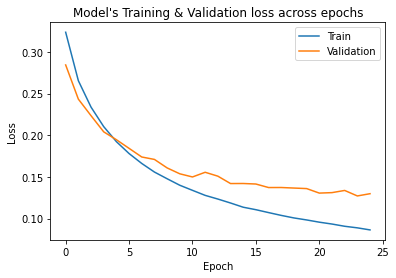

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Success! the model's loss consistently improves over the epochs, in both training and validation data.

#### Accuracy of the model over training

As we train the model, we also hope that it's accuracy in predictions will increase. How did the model fare over time?

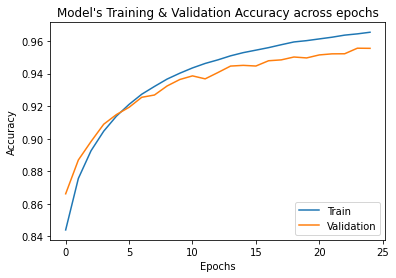

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model's Training & Validation Accuracy across epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Accuracy improves as we train, even on unseen data. This is exactly what we were hoping to see.

### Evaluating the Model

How well did the model learn the task? (Predicting which RedHat site visitors will become customers)

#### Accuracy

We'll have the model predict on each of the test entries and see how accurate it is.

In [ ]:
model.evaluate(X_test, y_test)

7587/7587 [==============================] - 16s 2ms/step - loss: 0.1304 - accuracy: 0.9548


[0.13041287660598755, 0.9548060894012451]

On the holdout data, the model is 95.5% accurate at separating customers from other site visitors, it seems like we've got ourselves a decent model.

#### AUC

What about [area under the receiver operating characteristic curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)?

AUC is an important metric that is frequently used for measuring how successful a model is at distinguishing between positive and negative outcomes in a binary-classification problem.

The closer the AUC is to 1, the better the model is; the closer to 0.5, the worse the model is.

In [ ]:
from keras.metrics import AUC
m = AUC()
m.update_state(y_test, model.predict(X_test))
print(m.result().numpy())

7587/7587 [==============================] - 10s 1ms/step
0.9895165


AUC of 0.989 is good, pat yourself on the back for successfully navigating this wonky dataset and training a successful deep neural network.

## Another Approach - Random Forest (Using Pandas)

#### Data Preprocessing

In [ ]:
import pandas as pd
act_train = pd.read_csv('act_train.csv')
act_test = pd.read_csv('act_test.csv')
people = pd.read_csv('people.csv')

In [ ]:
# Convert features in people and activities into integers

def preprocess_act(data, train_set=True):
    data = data.drop(['date', 'activity_id'], axis=1)
    if(train_set):
        data = data.drop(['outcome'], axis=1)
    
    data['people_id'] = data['people_id'].apply(lambda x: x.split('_')[1])
    data['people_id'] = pd.to_numeric(data['people_id']).astype(int)
    
    columns = list(data.columns)
    
    # Convert strings into integers
    for col in columns[1:]:
        data[col] = data[col].fillna('type 0')
        data[col] = data[col].apply(lambda x: x.split(' ')[1])
        data[col] = pd.to_numeric(data[col]).astype(int)
    return data


def preprocess_people(data):
    data = data.drop(['date'], axis=1)
    data['people_id'] = data['people_id'].apply(lambda x: x.split('_')[1])
    data['people_id'] = pd.to_numeric(data['people_id']).astype(int)
    
    # Values are booleans and strings    
    columns = list(data.columns)
    bools = columns[11:]
    strings = columns[1:11]
    
    for col in bools:
        data[col] = pd.to_numeric(data[col]).astype(int)        
    for col in strings:
        data[col] = data[col].fillna('type 0')
        data[col] = data[col].apply(lambda x: x.split(' ')[1])
        data[col] = pd.to_numeric(data[col]).astype(int)
    return data

In [ ]:
# Preprocess each df
people2 = preprocess_people(people)
action_train = preprocess_act(act_train)
action_test = preprocess_act(act_test, train_set=False)

#### Merging People and Activities

In [ ]:
# Merge into a unified table

# Training 
features = action_train.merge(people2, how='left', on='people_id')
labels = act_train['outcome']

# Testing
test = action_test.merge(people2, how='left', on='people_id')

features.sample(10)

,people_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
327413,150560,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,64
1829725,397500,4,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,0,1,0,43
146513,117883,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58
1836647,40482,2,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1,1,62
671469,2129,5,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,89
1419608,335146,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,1,98
983613,266504,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,89
464413,175936,2,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1,1,4
1264726,306770,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,50
1399409,331627,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,82


#### Splitting the Data into a Training Set and a Testing Set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=23)

#### Training a Random Forest Classifier

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

#### AUC

In [ ]:
probability = clf.predict_proba(X_test)
prediction = probability[:,1]
score = roc_auc_score(y_test, prediction)
print("Area under ROC (AUC): {0}".format(score))

Area under ROC (AUC): 0.9972296701621046


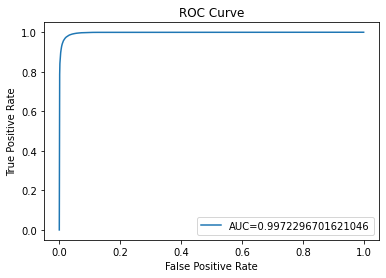

In [ ]:
# Plot
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  prediction)
auc = metrics.roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



<br>

<br>

<br>

<br>

<br>


## Results & Conclusion

We got a Catboost model with 87% accuracy on training data, and 87.2% accuracy on unseen (test) data. A (relatively) simple Keras Neural Network achieved 98.5% accuracy on training data, and 97.3% accuracy on unseen (test) data.
Additionally, the Random Forest model got an AUC score of 0.997.


## Lessons Learned - Data Leak

These results seemed shockingly good, so we dug a little bit deeper. We discovered that a large portion of the dataset consisted of completely duplicated data.


> **Artificially inflated “test” scores**


Removing these duplicates led to a slight decrease in the overall performance of both the tree-based models, and the neural network.


## Future Work


*   **Stochastic Gradient Descent** - If this data is generated from user actions on a website, we want to be able to shape our model continuously over time without retraining on the entire dataset each time.

*   **Time-Series** - Many users in this dataset perform a variety of different actions over time. Considering previous actions of a person (if any) may result in a model with greater predictive power.


*   **Streaming** - Considering RedHat as a relatively large company, it seems likely that this data is being generated at a high velocity, continuously. A true solution to this problem should be able to train and predict using streaming data, which makes Spark / Kafka strong candidates.
